# Lab 2: Entropy and Huffman Coding

#Introduction
The goal of this lab is to get familiar with how to compute the entropy for a
given image and learn how to do image and video compression through
Huffman Coding. You will take a greyscale frame, compress it with Huffman encoding and make some comparisons between the two frames.

Please follow these steps to prepare for the tasks:
1. Download the given video file in the course files and add it to the project files.
2. Import the libraries below.


In [1]:
#LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pylab

ModuleNotFoundError: No module named 'cv2'

#Tasks
Task 0. Greyscale conversion
1. Extract frame number 80 from the video file.
2. Convert the frame from RGB to YUV by using your function
“frameRGB2YUV”. For the rest of lab 2, we will only work on the Y layer of the YUV frame.

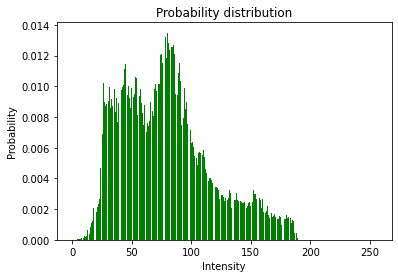

Entropy:  7.131208701376857


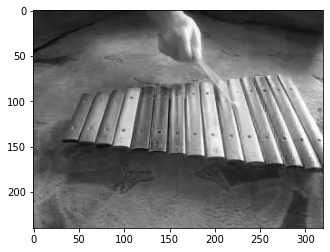

In [131]:
#VIDEO

# Here are the additional functions you will need to call in this lab
# y = Calcent(x)
# y = Huffmandict(x)
# y = Huffmanenco(x1, x2)
# y = Huffmandeco(x1, x2)

# Put your code from the VIDEO block from lab 1 here.

# Set up to read video. Set string to name of your clip.
cap = cv2.VideoCapture('test_video.mp4')

if cap.isOpened() == False:
    print("That's probably not the name of your clip")

# Some information about the video file
cap_e = int(cap.get(0)) # Elapsed video time in milliseconds
cap_w = int(cap.get(3)) # Frame width
cap_h = int(cap.get(4)) # Frame height
cap_r = int(cap.get(5)) # Frame rate
cap_l = int(cap.get(7)) # Length in number of frames
# Under VideoCapture::get is a list of attributes
# https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-open

# Reads frame number 80
stop = 80
for i in range(stop):
    ret, frame = cap.read()

    if i == stop-1:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        YUVframe = frameRGB2YUV(frame).astype(np.uint8)
        dim = YUVframe[:,:,0].shape
        p = Calcent(YUVframe[:,:,0])
        huff = Huffmandict(p)
        encoded_frame = Huffmanenco(YUVframe[:,:,0], huff)
        decoded_frame = Huffmandeco(encoded_frame, huff)
        plt.imshow(decoded_frame, cmap="gray")



In [5]:
#RGB2YUV

def frameRGB2YUV(RGBframe):
  # Transform RGB to YUV
  imagearray = np.array(RGBframe)
  imagearray = imagearray.astype("uint8")
  transform_matrix = np.array([[0.2126, 0.7152, 0.0722], [-0.09991, -0.33609, 0.436], [0.615, -0.55861, -0.05639]])
  YUVframe = np.matmul(imagearray, transform_matrix)
  y, u, v = cv2.split(YUVframe)

  # Downsamples/Upsamples
  dim_down = (int(u.shape[1] / 2), int(u.shape[0] / 2))
  dim_up = (int(u.shape[1]), int(u.shape[0]))
  
  u_comp = cv2.resize(cv2.resize(u, dim_down), dim_up)
  v_comp = cv2.resize(cv2.resize(v, dim_down), dim_up)

  YUVframe = cv2.merge((y, u_comp, v_comp))
  return YUVframe

Task 1. Entropy Calculation
1. Complete the function, “Calent” to calculate the entropy of
Y frame (that is, the Y layer of the YUV frame).
2. Display the probability distribution of intensities (nuances of grey) of the Y frame within function “Calcent”. Matplotlib is good for this. The entropy S can be calculated with $$S = -\sum_i{P_i\log_2{P_i}}$$

In [101]:
#ENTROPY
def Calcent(input):

  dictionary = {}

  value, counts = np.unique(input, return_counts=True)
  entropy = 0
  for i in range(256):
    if i in value:
      dictionary[i] = int(counts[value == i]) / input.size
    else:
      dictionary[i] = 0
      
    if dictionary[i] != 0:
      entropy += dictionary[i] * np.log2(dictionary[i])

  entropy *= -1
  
  # Plot the probability distribution
  plt.bar(dictionary.keys(), dictionary.values(), color='g')
  plt.xlabel('Intensity')
  plt.ylabel('Probability')
  plt.title('Probability distribution')
  plt.show()
  
  print("Entropy: ", entropy)
  return(dictionary)


Task 2: Huffman Coding

Here you will generate Huffman codes for the extracted Y frame and do
Huffman encoding and decoding.
1. Construct a Huffman codebook for the extracted Y frame by
the given function ‘Huffmandict’. Make sure to format your input correctly! There are more detailed instructions in the code block HUFFMAN DICTIONARY. Hint: If you want, you can create your dictionary in in the Calcent function, output it, and then use it as input for the Huffmandict function.
2. Implement Huffman encoding and decoding of the Y frame by
finishing the functions ‘Huffmanenco’ and ‘Huffmandeco’


In [73]:
import numpy as np
#HUFFMAN DICTIONARY

#!!!IMPORTANT!!! MAKE SURE THAT YOUR DICTIONARY'S NAME IS p

def Huffmandict(p):
  
  # This function generates a binary Huffman code dictionary 
  # Input should be a dictionary where the keys are the pixel intensities that
  # are found in your frame and the value of each key is the probability of 
  # that intensity to appear (i.e. FrequencyOfIntensity/TotalNumberOfPixels)
  # Consider this example: input = {'255':0.0312, '254':0.0000829, et cetera}
  # Output will be a dictionary where the keys are the pixel intensities 
  # found in your input dictionary, and the values are the binary codes for
  # the keys.

    '''Return a Huffman code for an ensemble with distribution p.'''
    normalizationFactor = sum(p.values())
    for k in p.keys():
      p[k] = p[k] / normalizationFactor
    EPSILON = 0.0001
    assert(sum(p.values()) > 1.0 - EPSILON) # Ensure probabilities sum to 1
    # Base case of only two symbols, assign 0 or 1 arbitrarily
    if len(p) == 2:
        return dict(zip(p.keys(), "01"))
    # Create a new distribution by merging lowest prob. pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[str(a1) + '|' + str(a2)] = p1 + p2
    # Recurse and construct code on new distribution
    c = Huffmandict(p_prime)
    ca1a2 = c.pop(str(a1) + '|' + str(a2))
    c[str(a1)], c[str(a2)] = ca1a2 + '0', ca1a2 + '1'
    return c
    
def lowest_prob_pair(p):
    '''Return pair of symbols from distribution p with lowest probabilities.'''
    assert(len(p) >= 2) # Ensure there are at least 2 symbols in the dist.

    sorted_p = sorted(p.items(), key=lambda x: x[1])

    return sorted_p[0][0], sorted_p[1][0]
    

# Example execution
example_dict = {'1':5/102,'2':7/102,'3':10/102,'4':15/102,'5':20/102,'6':45/102}
output = {}
output = Huffmandict(example_dict)
output

{'6': '0', '4': '110', '5': '111', '3': '100', '1': '1010', '2': '1011'}

In [106]:
#HUFFMAN ENCODING 
def Huffmanenco(OriginalImage, Huffdict):
  #print(OriginalImage)
  
  #print(Huffdict)
  output = []
  for i in range(OriginalImage.shape[0]):
    for j in range(OriginalImage.shape[1]):
      output.append(Huffdict[str(OriginalImage[i,j])])

  return output
  
encoded_frame = Huffmanenco(YUVframe[:,:,0], hoff)



In [127]:
#HUFFMAN DECODING
def Huffmandeco(EncodedImage, Huffdict):
  output = np.zeros(shape=dim)

  keys = list(Huffdict.keys())
  values = list(Huffdict.values())

  for i in range(dim[0]):
    for j in range(dim[1]):
        output[i,j] = keys[values.index(EncodedImage[i*dim[1]+j])]
  
  return output


# Report
Your report should fill the following criteria:
1. A first page with all your group members' names.
2. The photo of the Y frame you used in lab, its probability distribution, give the entropy H and show how you calculate it.
3. The information rate R of the compressed frame Y and code that shows how you get it; 
4. Description of the relationship between R and H , and computation of redundancy between R and H. 

Submit your report as a **single pdf**, combined from your text and your notebook as in Lab 1.

Upload your report to “Assignments/Lab2”.

Deadline is 29 April 2021 23:59